In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import matplotlib.cm as cm
import json
import os
from collections import defaultdict
import pandas as pd


In [ ]:
# result comp result
task = ['arc_challenge','arc_easy', 'boolq', 'gsm8k', 'hellaswag', 'openbookqa', 'piqa','winogrande','mbpp']
# gt = [76.6, 89.9, 89.4, 53.5, 92.6, 85.0, 69.9, 51.1, 52.1]
gt = [76.8, 89.4, 87.0, 46.2, 84.3, 81.8, 84.4, 57.0, 30.0]
# base = [65.4, 77.8, 71.6, 40.9, 49.7, 54.2, 72.8, 45.0, 43.1, 55.8]
base = [65.6, 77.8, 71.8, 41.7, 49.5, 54.4, 72.8, 45.3, 44.1]

gt_map = dict(zip(task, gt))
base_map = dict(zip(task, base))


def convert_csv_to_data_str(file_path: str, lmbda: int) -> str:
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        return f"Error: The file was not found at {file_path}"
    
    output_data = {lmbda: {}}
    
    if df.empty:
        return "Error: The CSV file is empty."
    data_row = df.iloc[0]

    for col_name, value in data_row.items():
        # '.results.'를 포함하는 컬럼만 처리 (acc, mbpp_base_pass@1 등)
        if '.results.' in col_name:
            # 컬럼 이름을 task 이름과 metric 이름으로 분리
            parts = col_name.split('.results.')
            task_name = parts[0]
            metric_name = parts[1]
            
            # task가 딕셔너리에 없으면 새로 생성
            if task_name not in output_data[lmbda]:
                output_data[lmbda][task_name] = {}
            
            # metric 값 저장 (숫자 형태로 변환)
            output_data[lmbda][task_name][metric_name] = float(value)

    # 4. 누락된 'bpp' 값을 모든 task에 추가
    # CSV에 bpp 정보가 없으므로 None으로 채웁니다. 
    # 실제 bpp 값이 있다면 이 부분을 수정하여 채울 수 있습니다.
    for task_name in output_data[lmbda]:
        if 'bpp' not in output_data[lmbda][task_name]:
            output_data[lmbda][task_name]['bpp'] = None # bpp 정보가 없으므로 None으로 설정
            
    # 5. 최종 딕셔너리를 보기 좋은 형태의 문자열로 변환
    # json.dumps를 사용하여 이전 질문의 data_str과 동일한 포맷을 만듭니다.
    # data_str = json.dumps(output_data, indent=4)
    return output_data


lmbdas = [100, 1000, 10000, 100000]
iters = [170000, 170000, 170000, 170000]
total_result = {}
for lm, it in zip(lmbdas, iters):
    path = f'/workspace/Weight_compression/text-to-lora/train_outputs/compnet_recon/compnet/v4_ld{lm}_'
    results = {}
    for t in task:
        rspath = os.path.join(path, 'eval_results', f'{t}_it{it}_eval_results.json')
        with open(rspath, 'r') as f:
            data = json.load(f)
            try:
                results[t] = {'acc': data[t][0]['results']['acc']}
            except:
                results[t] = {'mbpp_base_pass@1': data[t][0]['results']['mbpp_base_pass@1']}
                
    total_result[lm] = results
    
    mpath = os.path.join(path, 'eval_results', f'comp_metrics_itNone.json')
    with open(mpath, 'r') as f:
        data = json.load(f)
    for t in task:
        bit_sum = 0
        n_parm = 0
        mse_sum = 0
        for k, v in data[t].items():
            bit_sum += v['bpp_A'] * v['num_params_A']
            bit_sum += v['bpp_B'] * v['num_params_B']
            mse_sum += v['mse_B'] * v['num_params_B'] +  v['mse_A'] * v['num_params_A']
            n_parm += v['num_params_B'] + v['num_params_A']            
        results[t]['bpp'] = bit_sum / n_parm
        results[t]['mse'] = mse_sum / n_parm


csv_file_path = '/workspace/Weight_compression/text-to-lora/train_outputs/compnet_recon/compnet/v4_ld50_20250910-093437_m1ygdR2L/eval_results/combined_results_it110000.csv'
lmbda_value = 50
out = convert_csv_to_data_str(csv_file_path, lmbda_value)
mpath = '/'+ os.path.join(*csv_file_path.split('/')[:-1], 'comp_metrics_it110000.json')
with open(mpath, 'r') as f:
    data = json.load(f)
for t in task:
    bit_sum = 0
    n_parm = 0
    mse_sum = 0
    for k, v in data[t].items():
        bit_sum += v['bpp_A'] * v['num_params_A']
        bit_sum += v['bpp_B'] * v['num_params_B']
        mse_sum += v['mse_B'] * v['num_params_B'] +  v['mse_A'] * v['num_params_A']
        n_parm += v['num_params_B'] + v['num_params_A']                 
    out[lmbda_value][t]['bpp'] = bit_sum / n_parm
    out[lmbda_value][t]['mse'] = mse_sum / n_parm
del out[lmbda_value]['avg']
total_result.update(out)

In [ ]:
# Read quant results
import glob
quant_result = {}
bits = [2, 3, 4, 5, 6, 7, 8]
base_dir = "/workspace/Weight_compression/text-to-lora/train_outputs/qunat_lora/group128"
dirname = "eval_resultsA_group_{bit}_128_B_group_{bit}_128_full_eval"
quant_result = {}
for b in bits:
    quant_result[b] = {}

    listdir = glob.glob(f'{base_dir}/{dirname.format(bit = b)}/*eval_results.json')
    metric_path = f'{base_dir}/{dirname.format(bit = b)}/quant_metrics.json'
    with open(metric_path, 'r') as f:
        metric = json.load(f)
        
    for l in listdir:
        with open(l, 'r') as f:
            data = json.load(f)
        
        eval_ds = list(data.keys())[0]
        results = {}
        try:
            results = {'acc': data[eval_ds][0]['results']['acc']}
        except:
            results = {'mbpp_base_pass@1': data[eval_ds][0]['results']['mbpp_base_pass@1']}
        
        m = metric[eval_ds]
        bit_sum = 0
        n_parm = 0
        mse_sum = 0
        for k, v in m.items():
            bit_sum += v['bppA'] * v['num_params_A']
            bit_sum += v['bppB'] * v['num_params_B']
            mse_sum += v['mse_B'] * v['num_params_B'] +  v['mse_A'] * v['num_params_A']
            n_parm += v['num_params_B'] + v['num_params_A']
        bpp = bit_sum / n_parm
        mse = mse_sum / n_parm
        
        results['bpp'] = bpp
        results['mse'] = mse
        
        quant_result[b][eval_ds] = results
        

In [31]:
quant_result

{2: {'gsm8k': {'acc': 0.4852160727824109,
   'bpp': 2.125,
   'mse': 2.199777433221383e-05},
  'arc_challenge': {'acc': 0.7679180887372014,
   'bpp': 2.125,
   'mse': 2.5195175217399643e-05},
  'winogrande': {'acc': 0.5698500394632992,
   'bpp': 2.125,
   'mse': 1.4631265015142302e-05},
  'openbookqa': {'acc': 0.806, 'bpp': 2.125, 'mse': 2.722600234287361e-05},
  'arc_easy': {'acc': 0.890993265993266,
   'bpp': 2.125,
   'mse': 2.0809594913701472e-05},
  'mbpp': {'mbpp_base_pass@1': 0.2756892230576441,
   'bpp': 2.125,
   'mse': 2.1705384124988297e-05},
  'hellaswag': {'acc': 0.8227444732125074,
   'bpp': 2.125,
   'mse': 1.620545376113114e-05},
  'boolq': {'acc': 0.8311926605504587,
   'bpp': 2.125,
   'mse': 1.5199888740478575e-05},
  'piqa': {'acc': 0.8394994559303591,
   'bpp': 2.125,
   'mse': 1.4585402777374138e-05}},
 3: {'gsm8k': {'acc': 0.46398786959818045,
   'bpp': 3.125,
   'mse': 2.185926276227362e-06},
  'arc_challenge': {'acc': 0.7704778156996587,
   'bpp': 3.125,
   'ms

정확도 그래프가 'bpp_vs_acc_with_gt_and_avg.png' 파일로 저장되었습니다.
MSE 그래프가 'bpp_vs_mse_by_task.png' 파일로 저장되었습니다.


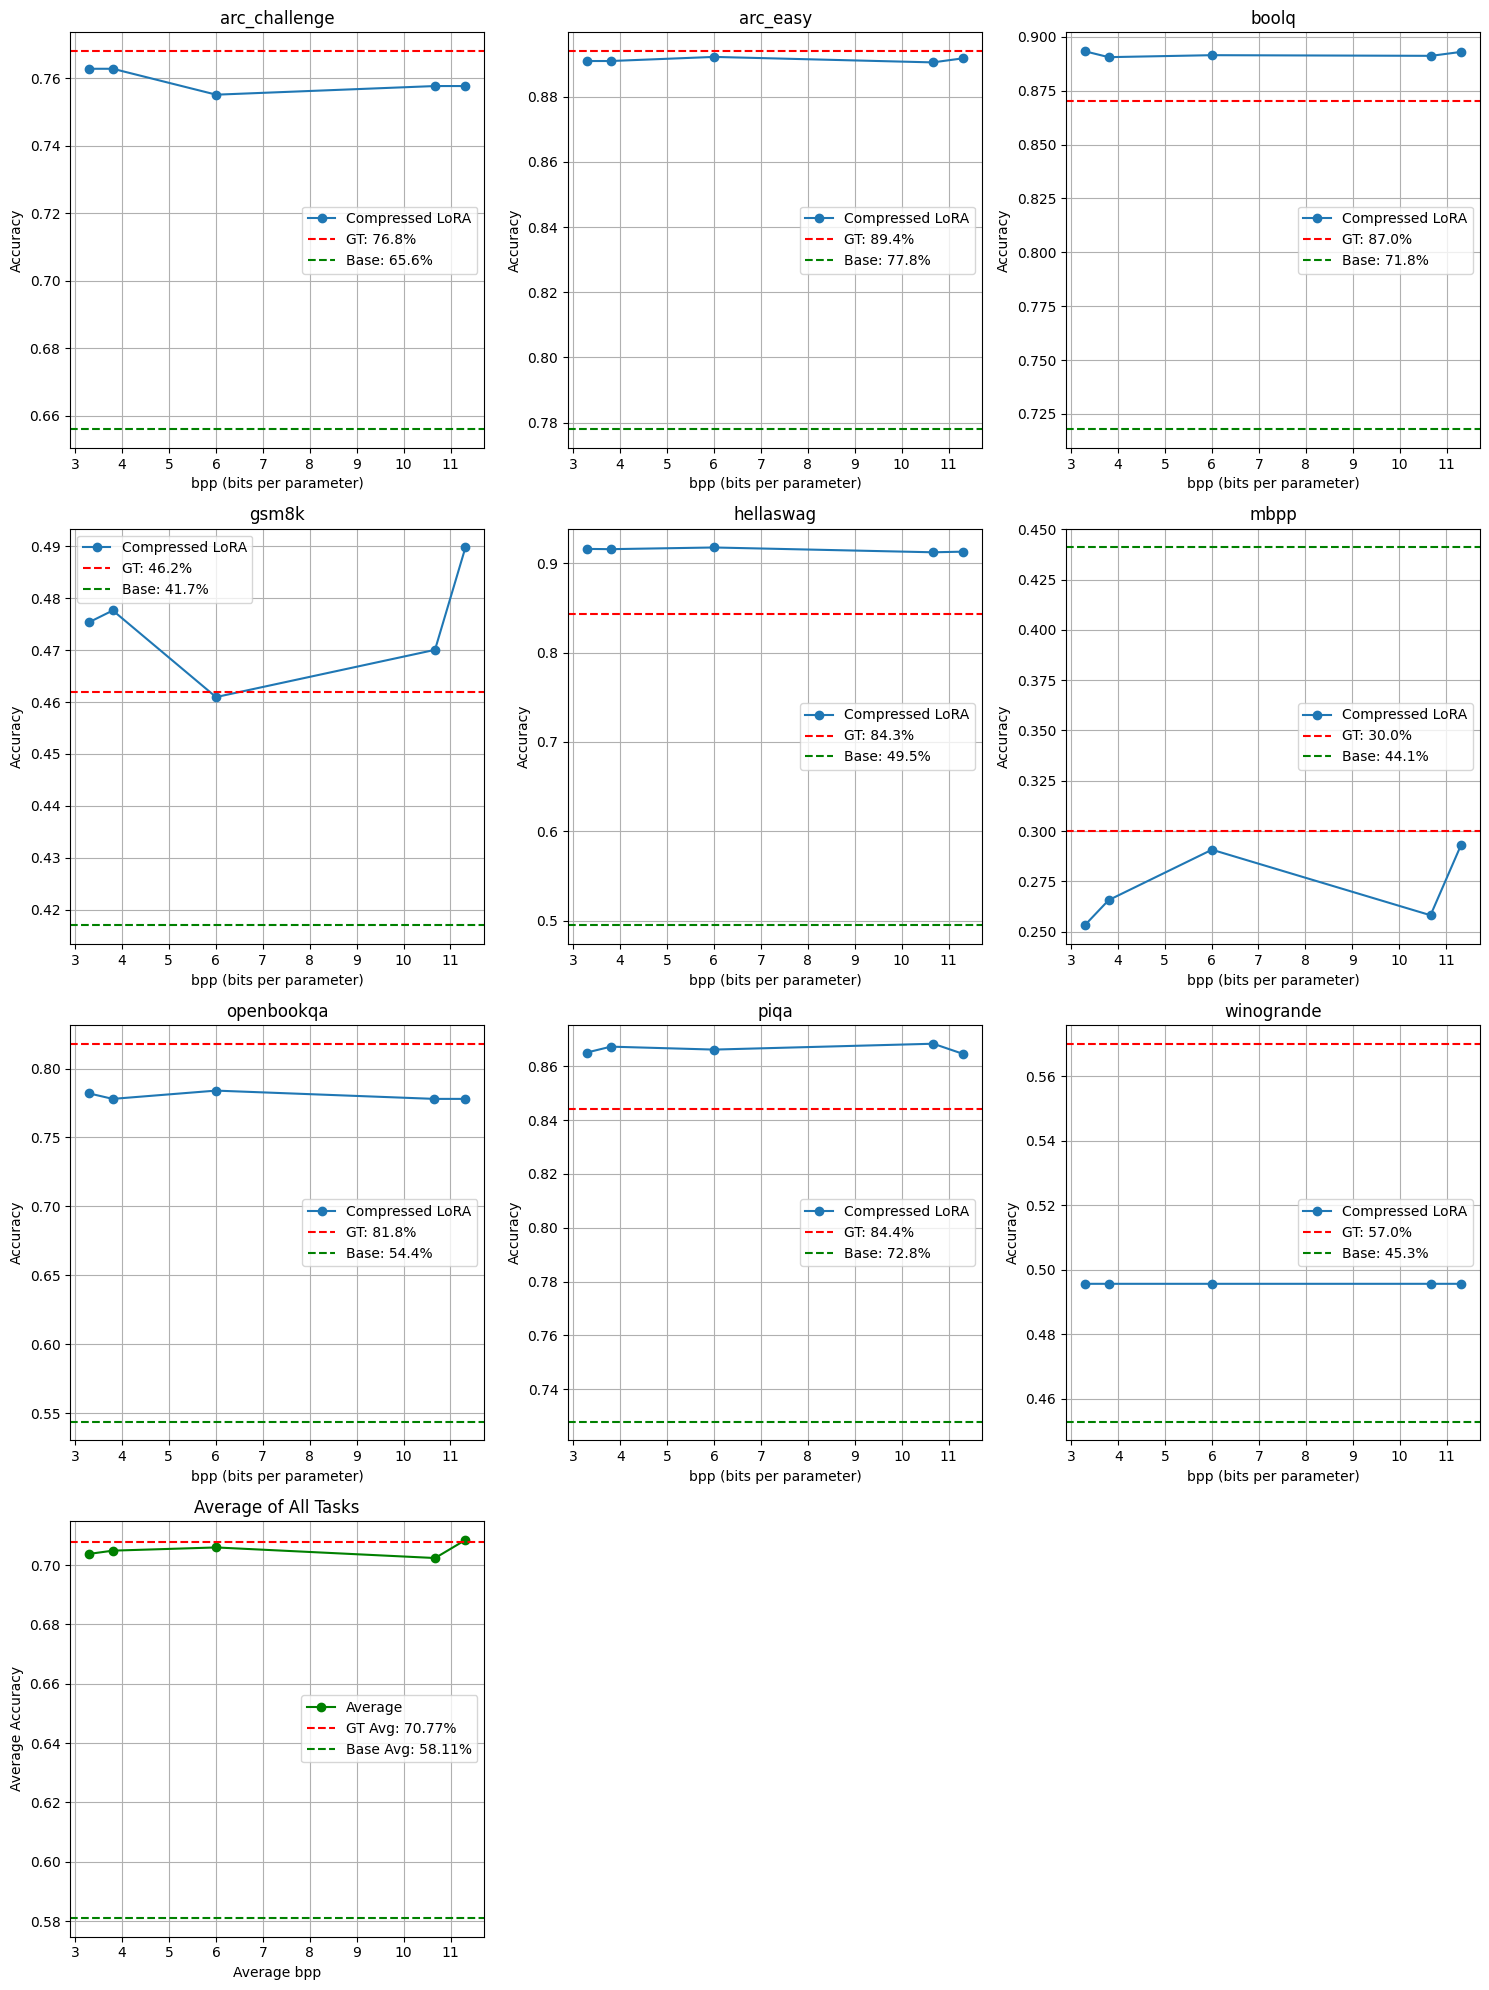

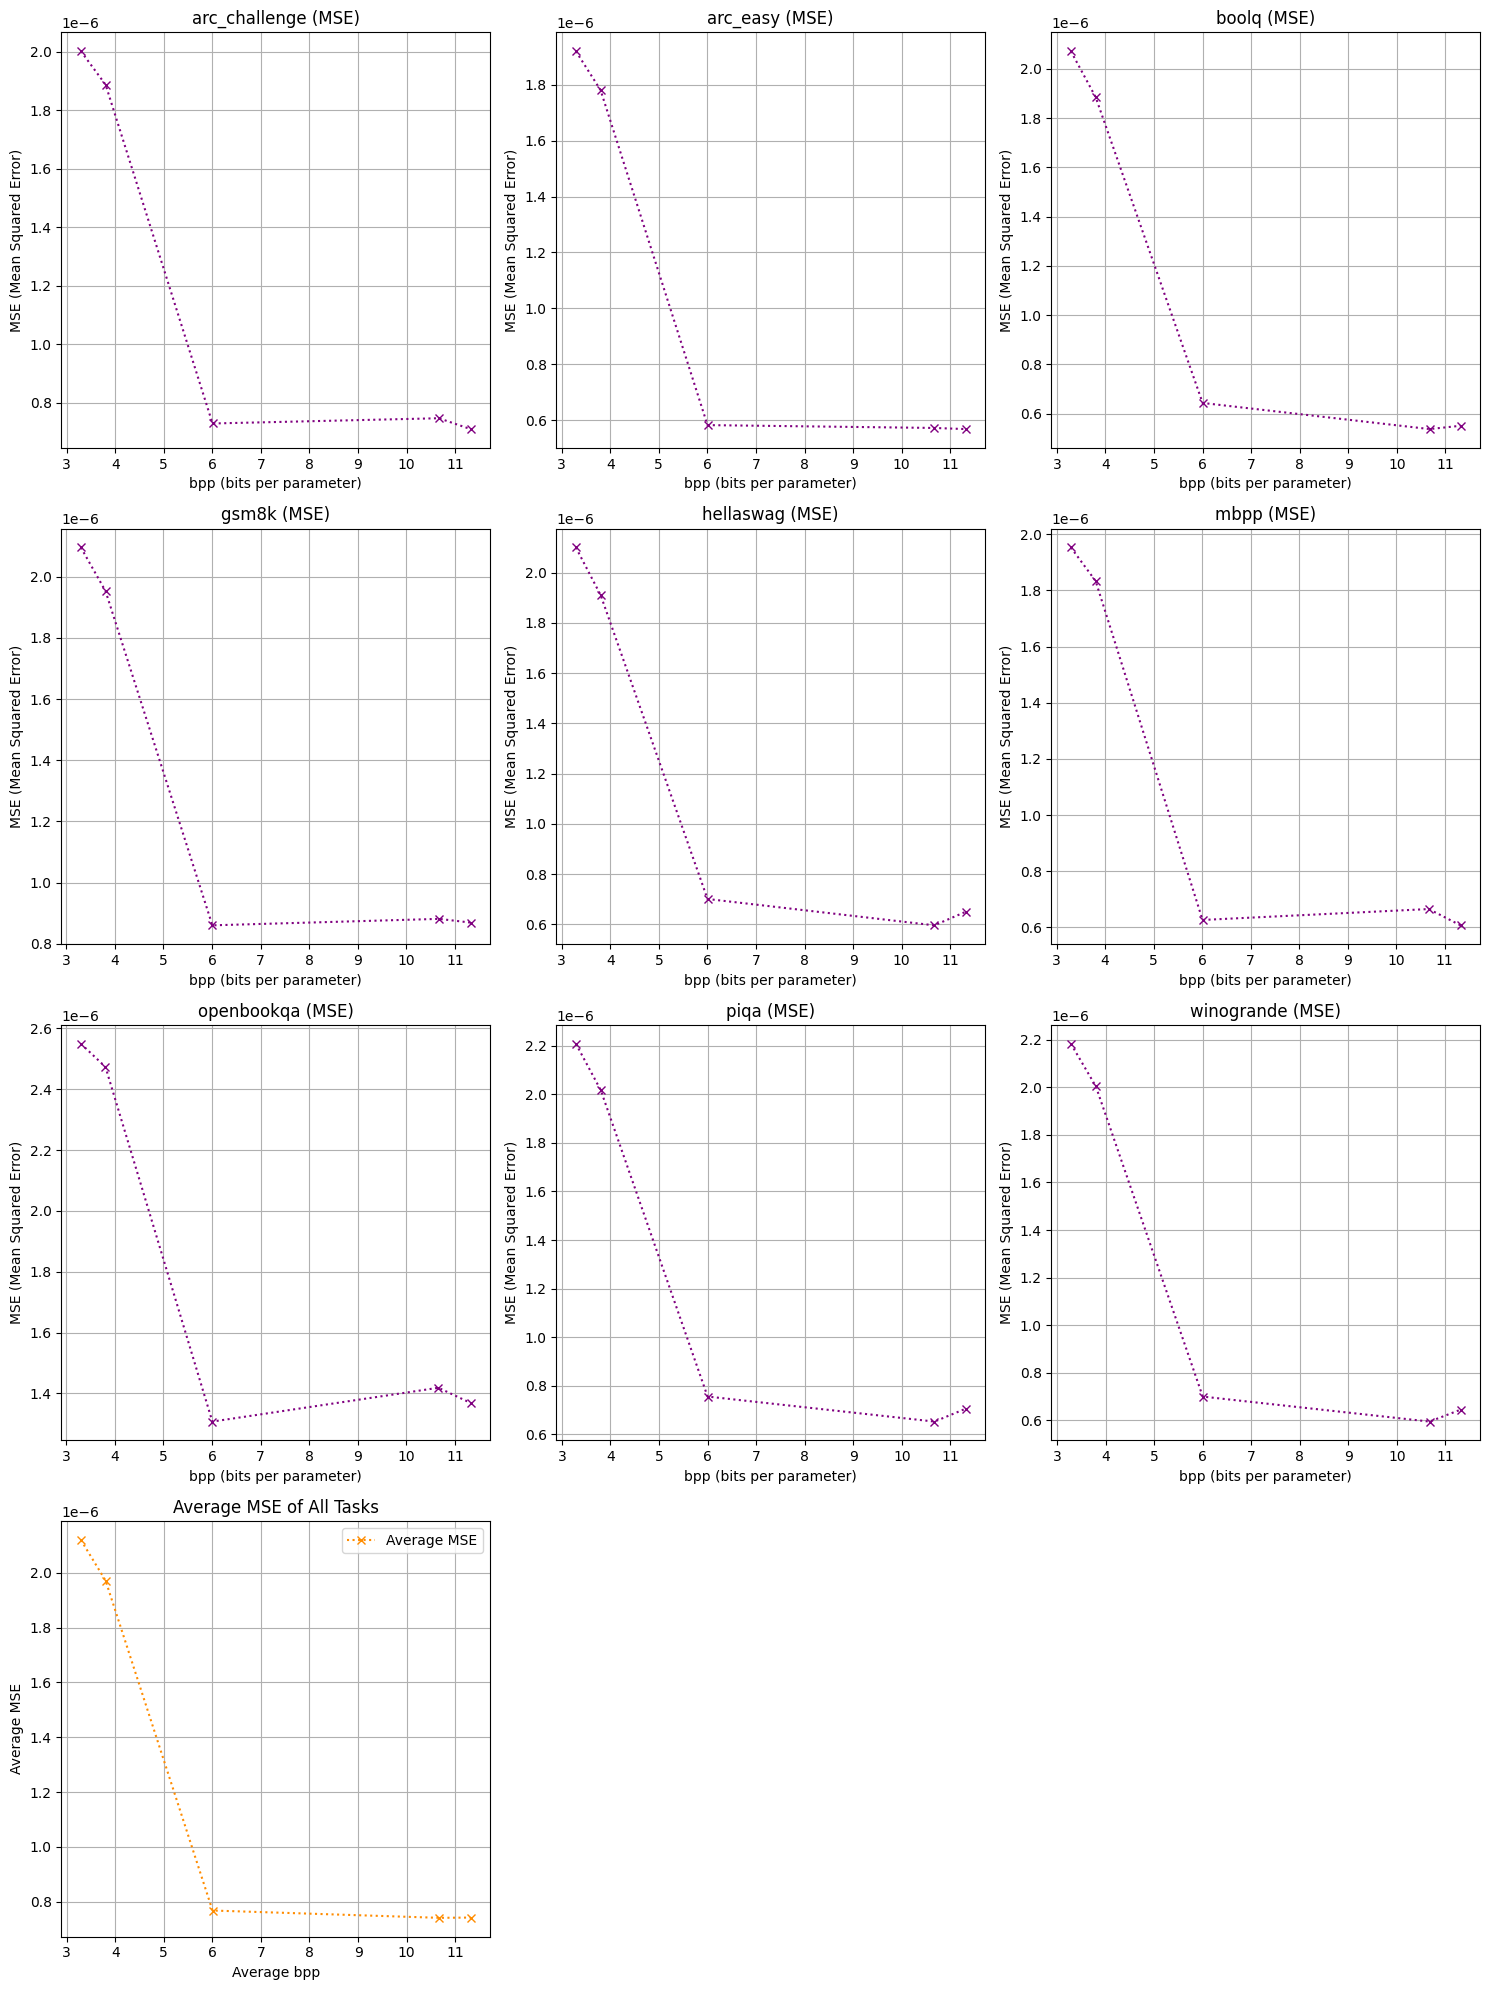

In [ ]:
task_data = defaultdict(lambda: {'bpp': [], 'acc': [], 'mse': []})
average_data = defaultdict(list)
data = total_result

for step, tasks in data.items():
    step_bpps = []
    step_accs = []
    step_mses = [] # MSE 평균 계산용 리스트 추가
    for task_name, metrics in tasks.items():
        # bpp, acc, mse 값 추출
        bpp = metrics['bpp']
        mse = metrics.get('mse', 0.0) # mse 키가 없을 경우 0으로 처리

        if 'acc' in metrics:
            acc = metrics['acc']
        elif 'mbpp_base_pass@1' in metrics:
            acc = metrics['mbpp_base_pass@1']
        
        # task별 데이터 저장
        task_data[task_name]['bpp'].append(bpp)
        task_data[task_name]['acc'].append(acc)
        task_data[task_name]['mse'].append(mse)
        
        # 평균 계산을 위해 현재 step의 데이터 저장
        step_bpps.append(bpp)
        step_accs.append(acc)
        step_mses.append(mse)
    
    # 현재 step의 평균 bpp, acc, mse를 average_data에 저장
    if step_bpps:
        average_data['bpp'].append(np.mean(step_bpps))
        average_data['acc'].append(np.mean(step_accs))
        average_data['mse'].append(np.mean(step_mses))


# ==================== 2. 정확도(Accuracy) 그래프 그리기 ====================
task_names = sorted(task_data.keys())
num_tasks = len(task_names)
num_plots = num_tasks + 1
cols = 3
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

for i, task_name in enumerate(task_names):
    ax = axes[i]
    points = sorted(zip(task_data[task_name]['bpp'], task_data[task_name]['acc']))
    bpp_sorted = [p[0] for p in points]
    acc_sorted = [p[1] for p in points]
    
    ax.plot(bpp_sorted, acc_sorted, marker='o', linestyle='-', label='Compressed LoRA')
    
    if task_name in gt_map:
        gt_value = gt_map[task_name]
        b_value = base_map[task_name]
        ax.axhline(y=gt_value / 100.0, color='r', linestyle='--', label=f'GT: {gt_value}%')
        ax.axhline(y=b_value / 100.0, color='g', linestyle='--', label=f'Base: {b_value}%')
    ax.legend()
    
    ax.set_title(task_name)
    ax.set_xlabel("bpp (bits per parameter)")
    ax.set_ylabel("Accuracy")
    ax.grid(True)

# 정확도 평균 그래프
ax = axes[num_tasks]
avg_points = sorted(zip(average_data['bpp'], average_data['acc']))
avg_bpp_sorted = [p[0] for p in avg_points]
avg_acc_sorted = [p[1] for p in avg_points]

ax.plot(avg_bpp_sorted, avg_acc_sorted, marker='o', linestyle='-', color='green', label='Average')
ax.axhline(y=np.mean(gt) / 100.0, color='r', linestyle='--', label=f'GT Avg: {np.mean(gt):.2f}%')
ax.axhline(y=np.mean(base) / 100.0, color='g', linestyle='--', label=f'Base Avg: {np.mean(base):.2f}%')
ax.set_title("Average of All Tasks")
ax.set_xlabel("Average bpp")
ax.set_ylabel("Average Accuracy")
ax.grid(True)
ax.legend()

for j in range(num_plots, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
# plt.savefig("bpp_vs_acc_with_gt_and_avg.png")
# print("정확도 그래프가 'bpp_vs_acc_with_gt_and_avg.png' 파일로 저장되었습니다.")


# ==================== 3. MSE 그래프 그리기 (새로운 그림) ====================
fig_mse, axes_mse = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes_mse = axes_mse.flatten()

for i, task_name in enumerate(task_names):
    ax = axes_mse[i]
    
    # bpp 값을 기준으로 MSE 데이터 정렬
    points = sorted(zip(task_data[task_name]['bpp'], task_data[task_name]['mse']))
    bpp_sorted = [p[0] for p in points]
    mse_sorted = [p[1] for p in points]
    
    ax.plot(bpp_sorted, mse_sorted, marker='x', linestyle=':', color='purple')
    
    ax.set_title(f"{task_name} (MSE)")
    ax.set_xlabel("bpp (bits per parameter)")
    ax.set_ylabel("MSE (Mean Squared Error)")
    ax.grid(True)
    # MSE 값은 매우 작을 수 있으므로 과학적 표기법 사용
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# MSE 평균 그래프
ax = axes_mse[num_tasks]
avg_points_mse = sorted(zip(average_data['bpp'], average_data['mse']))
avg_bpp_sorted_mse = [p[0] for p in avg_points_mse]
avg_mse_sorted = [p[1] for p in avg_points_mse]

ax.plot(avg_bpp_sorted_mse, avg_mse_sorted, marker='x', linestyle=':', color='darkorange', label='Average MSE')
ax.set_title("Average MSE of All Tasks")
ax.set_xlabel("Average bpp")
ax.set_ylabel("Average MSE")
ax.grid(True)
ax.legend()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# 남는 subplot 숨기기
for j in range(num_plots, len(axes_mse)):
    axes_mse[j].set_visible(False)

plt.tight_layout()
# plt.savefig("bpp_vs_mse_by_task.png")
# print("MSE 그래프가 'bpp_vs_mse_by_task.png' 파일로 저장되었습니다.")

# 모든 그래프를 화면에 표시 (Jupyter Notebook 등에서 유용)
plt.show()


정확도 그래프가 'bpp_vs_acc_with_gt_and_avg.png' 파일로 저장되었습니다.
MSE 비교 그래프가 'bpp_vs_mse_by_task_comparison.png' 파일로 저장되었습니다.


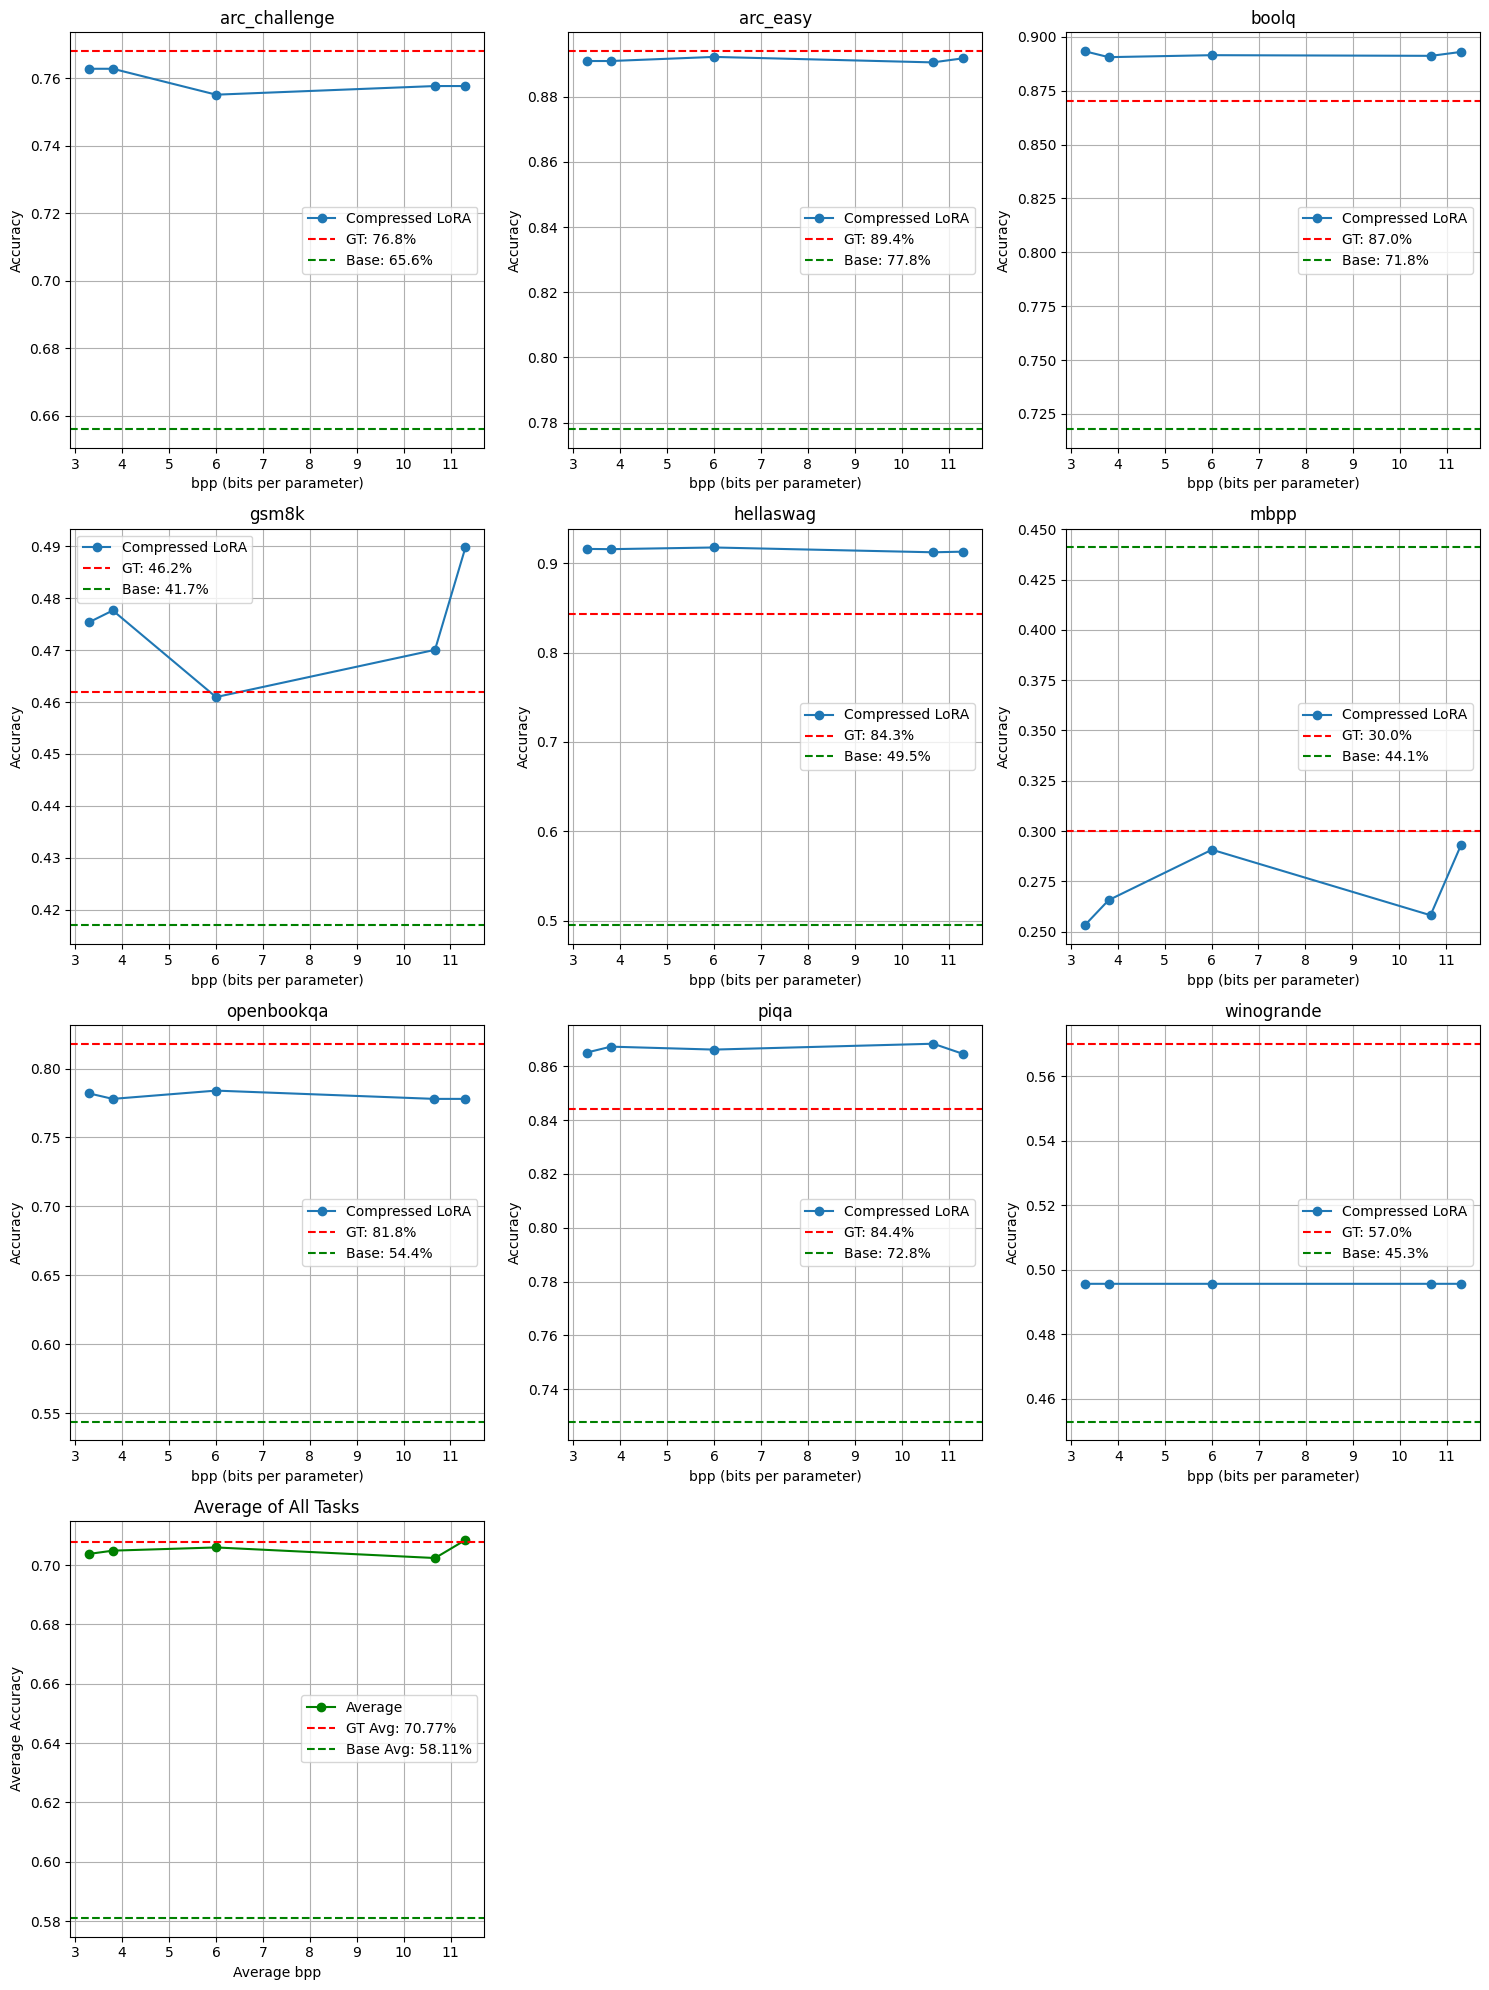

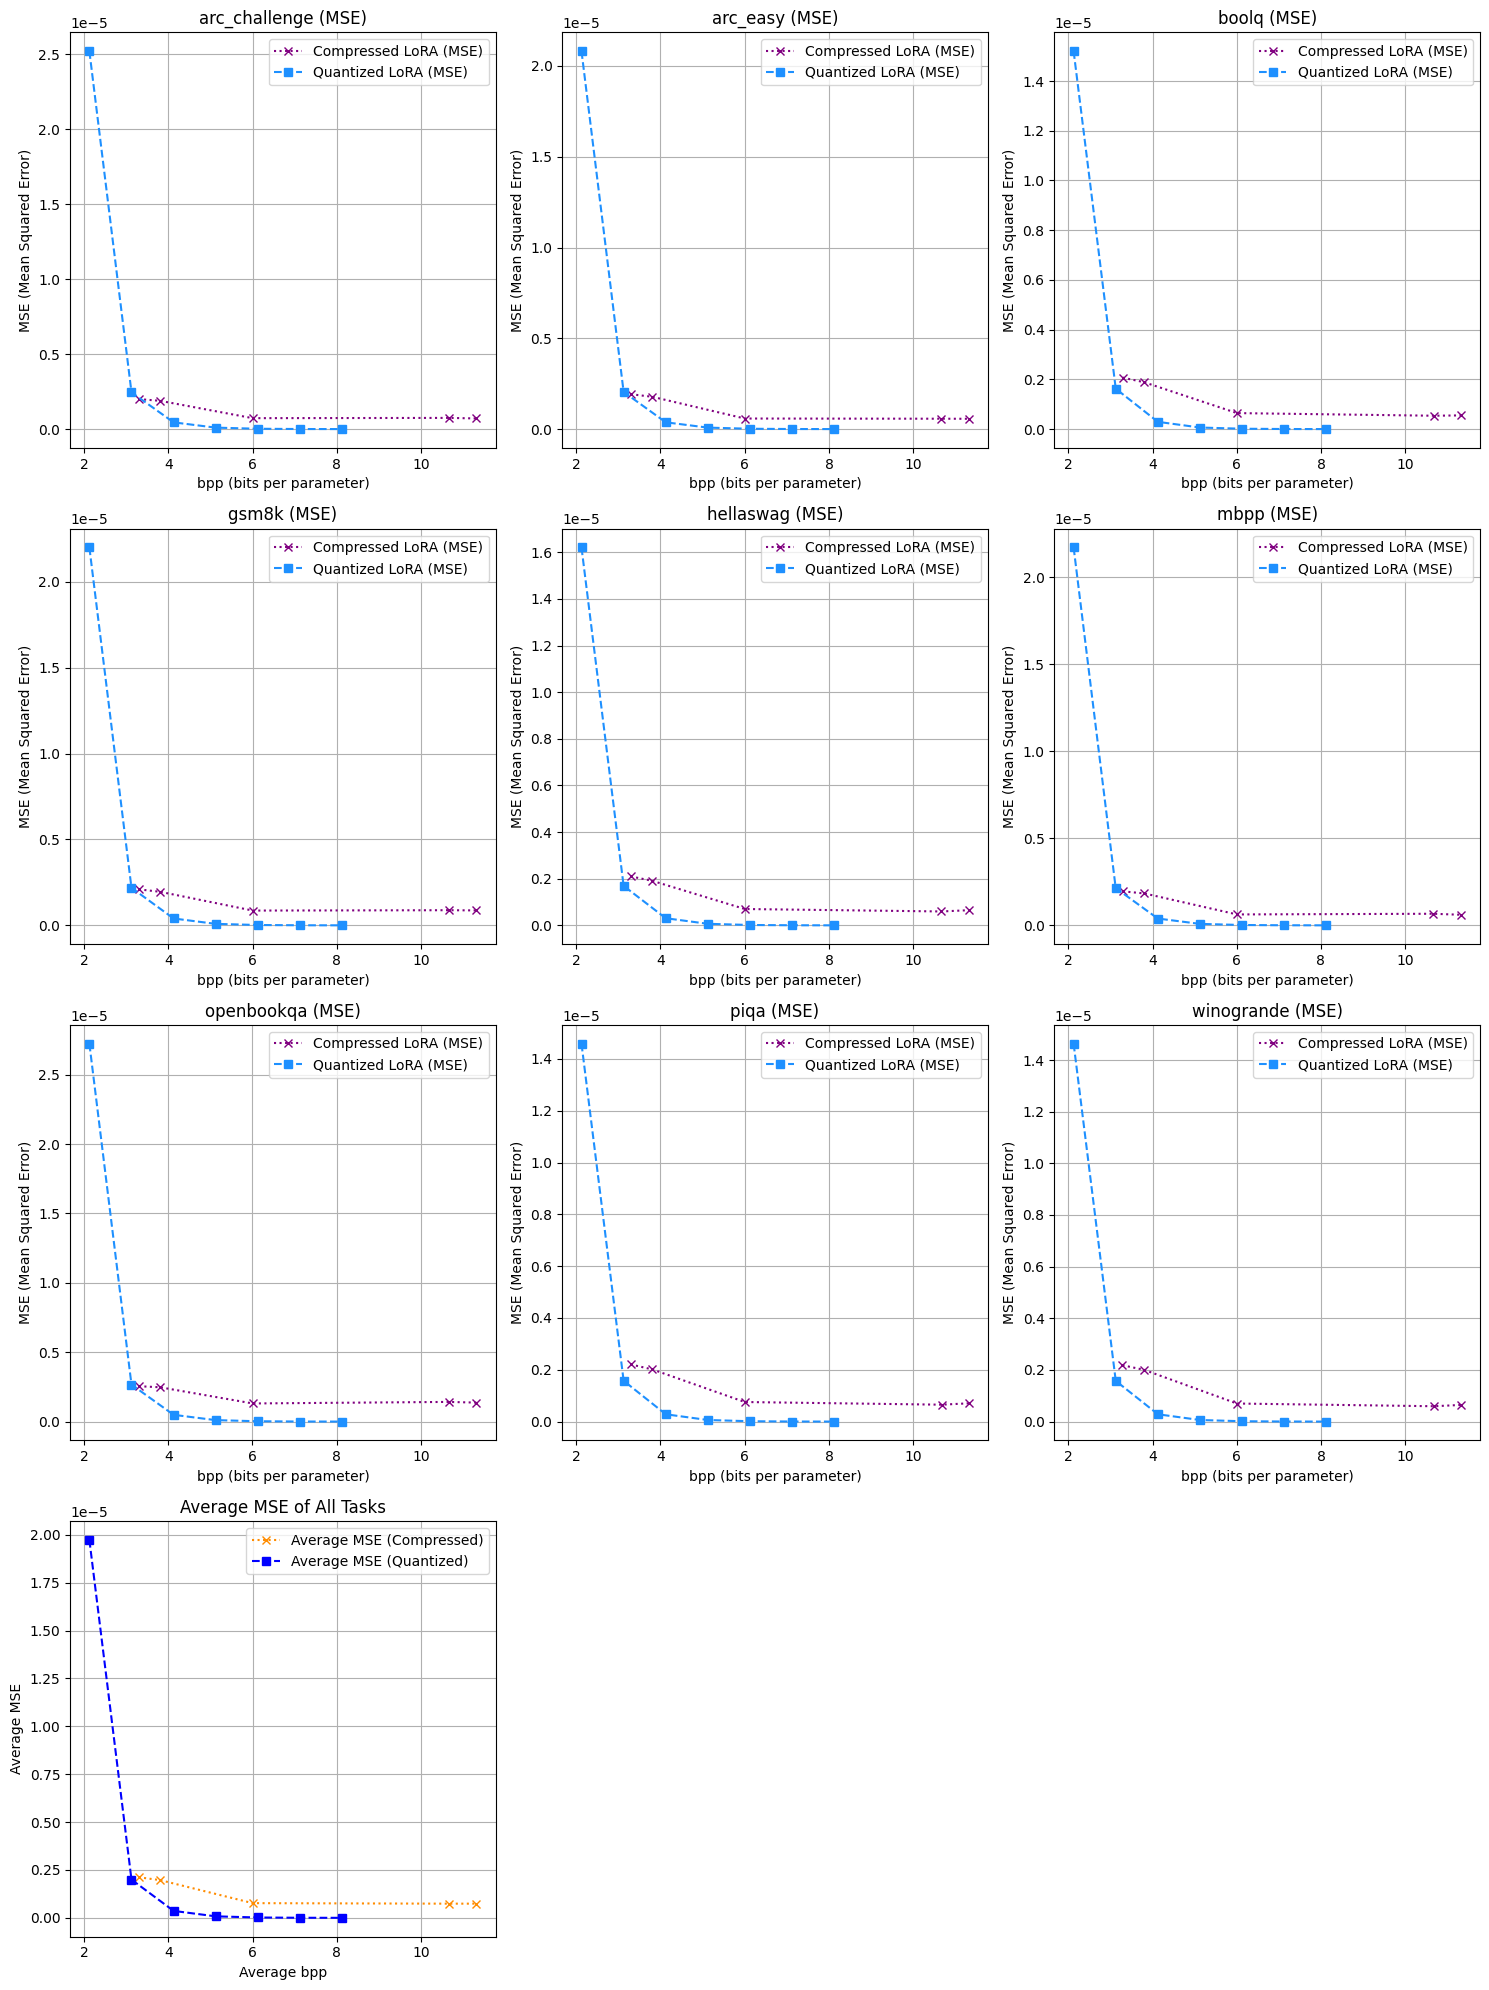

In [ ]:

# ==================== 1. 데이터 재구성 (두 데이터셋 모두 처리) ====================
# total_result 처리
task_data = defaultdict(lambda: {'bpp': [], 'acc': [], 'mse': []})
average_data = defaultdict(list)
data = total_result # data 변수명 유지

for step, tasks_data in data.items():
    step_bpps, step_accs, step_mses = [], [], []
    for task_name, metrics in tasks_data.items():
        if task_name not in tasks: continue # 정의된 태스크만 처리
        bpp, mse = metrics['bpp'], metrics.get('mse', 0.0)
        acc = metrics.get('acc') or metrics.get('mbpp_base_pass@1')
        
        task_data[task_name]['bpp'].append(bpp)
        task_data[task_name]['acc'].append(acc)
        task_data[task_name]['mse'].append(mse)
        
        step_bpps.append(bpp)
        step_accs.append(acc)
        step_mses.append(mse)
    
    if step_bpps:
        average_data['bpp'].append(np.mean(step_bpps))
        average_data['acc'].append(np.mean(step_accs))
        average_data['mse'].append(np.mean(step_mses))

# quant_result 처리
quant_task_data = defaultdict(lambda: {'bpp': [], 'mse': []})
quant_average_data = defaultdict(list)

for step, tasks_data in quant_result.items():
    step_bpps, step_mses = [], []
    for task_name, metrics in tasks_data.items():
        if task_name not in tasks: continue # 정의된 태스크만 처리
        bpp, mse = metrics['bpp'], metrics.get('mse', 0.0)
        
        quant_task_data[task_name]['bpp'].append(bpp)
        quant_task_data[task_name]['mse'].append(mse)
        
        step_bpps.append(bpp)
        step_mses.append(mse)

    if step_bpps:
        quant_average_data['bpp'].append(np.mean(step_bpps))
        quant_average_data['mse'].append(np.mean(step_mses))
# =================================================================================

# ==================== 2. 정확도(Accuracy) 그래프 그리기 (변경 없음) ====================
task_names = sorted(task_data.keys())
num_tasks = len(task_names)
num_plots = num_tasks + 1
cols = 3
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

for i, task_name in enumerate(task_names):
    ax = axes[i]
    points = sorted(zip(task_data[task_name]['bpp'], task_data[task_name]['acc']))
    bpp_sorted = [p[0] for p in points]
    acc_sorted = [p[1] for p in points]
    
    ax.plot(bpp_sorted, acc_sorted, marker='o', linestyle='-', label='Compressed LoRA')
    
    if task_name in gt_map:
        gt_value, b_value = gt_map[task_name], base_map[task_name]
        ax.axhline(y=gt_value / 100.0, color='r', linestyle='--', label=f'GT: {gt_value}%')
        ax.axhline(y=b_value / 100.0, color='g', linestyle='--', label=f'Base: {b_value}%')
    ax.legend()
    
    ax.set_title(task_name)
    ax.set_xlabel("bpp (bits per parameter)")
    ax.set_ylabel("Accuracy")
    ax.grid(True)

ax = axes[num_tasks]
avg_points = sorted(zip(average_data['bpp'], average_data['acc']))
ax.plot([p[0] for p in avg_points], [p[1] for p in avg_points], marker='o', linestyle='-', color='green', label='Average')
ax.axhline(y=np.mean(gt) / 100.0, color='r', linestyle='--', label=f'GT Avg: {np.mean(gt):.2f}%')
ax.axhline(y=np.mean(base) / 100.0, color='g', linestyle='--', label=f'Base Avg: {np.mean(base):.2f}%')
ax.set_title("Average of All Tasks")
ax.set_xlabel("Average bpp")
ax.set_ylabel("Average Accuracy")
ax.grid(True)
ax.legend()

for j in range(num_plots, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
# plt.savefig("bpp_vs_acc_with_gt_and_avg.png")
# print("정확도 그래프가 'bpp_vs_acc_with_gt_and_avg.png' 파일로 저장되었습니다.")


# ==================== 3. MSE 그래프 그리기 (Quantized LoRA 추가) ====================
fig_mse, axes_mse = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes_mse = axes_mse.flatten()

for i, task_name in enumerate(task_names):
    ax = axes_mse[i]
    
    # 1. 기존 데이터 (Compressed LoRA) 그리기
    points = sorted(zip(task_data[task_name]['bpp'], task_data[task_name]['mse']))
    bpp_sorted = [p[0] for p in points]
    mse_sorted = [p[1] for p in points]
    ax.plot(bpp_sorted, mse_sorted, marker='x', linestyle=':', color='purple', label='Compressed LoRA (MSE)')
    
    # 2. 새로운 데이터 (Quantized LoRA) 그리기
    if task_name in quant_task_data:
        quant_points = sorted(zip(quant_task_data[task_name]['bpp'], quant_task_data[task_name]['mse']))
        quant_bpp_sorted = [p[0] for p in quant_points]
        quant_mse_sorted = [p[1] for p in quant_points]
        ax.plot(quant_bpp_sorted, quant_mse_sorted, marker='s', linestyle='--', color='dodgerblue', label='Quantized LoRA (MSE)')

    ax.set_title(f"{task_name} (MSE)")
    ax.set_xlabel("bpp (bits per parameter)")
    ax.set_ylabel("MSE (Mean Squared Error)")
    ax.grid(True)
    ax.legend()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# MSE 평균 그래프
ax = axes_mse[num_tasks]
# 1. 기존 데이터 평균
avg_points_mse = sorted(zip(average_data['bpp'], average_data['mse']))
ax.plot([p[0] for p in avg_points_mse], [p[1] for p in avg_points_mse], marker='x', linestyle=':', color='darkorange', label='Average MSE (Compressed)')
# 2. 새로운 데이터 평균
quant_avg_points_mse = sorted(zip(quant_average_data['bpp'], quant_average_data['mse']))
ax.plot([p[0] for p in quant_avg_points_mse], [p[1] for p in quant_avg_points_mse], marker='s', linestyle='--', color='blue', label='Average MSE (Quantized)')

ax.set_title("Average MSE of All Tasks")
ax.set_xlabel("Average bpp")
ax.set_ylabel("Average MSE")
ax.grid(True)
ax.legend()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

for j in range(num_plots, len(axes_mse)):
    axes_mse[j].set_visible(False)

plt.tight_layout()
# plt.savefig("bpp_vs_mse_by_task_comparison.png")
# print("MSE 비교 그래프가 'bpp_vs_mse_by_task_comparison.png' 파일로 저장되었습니다.")

plt.show()

정확도 비교 그래프가 'bpp_vs_acc_comparison.png' 파일로 저장되었습니다.
MSE 비교 그래프가 'bpp_vs_mse_by_task_comparison.png' 파일로 저장되었습니다.


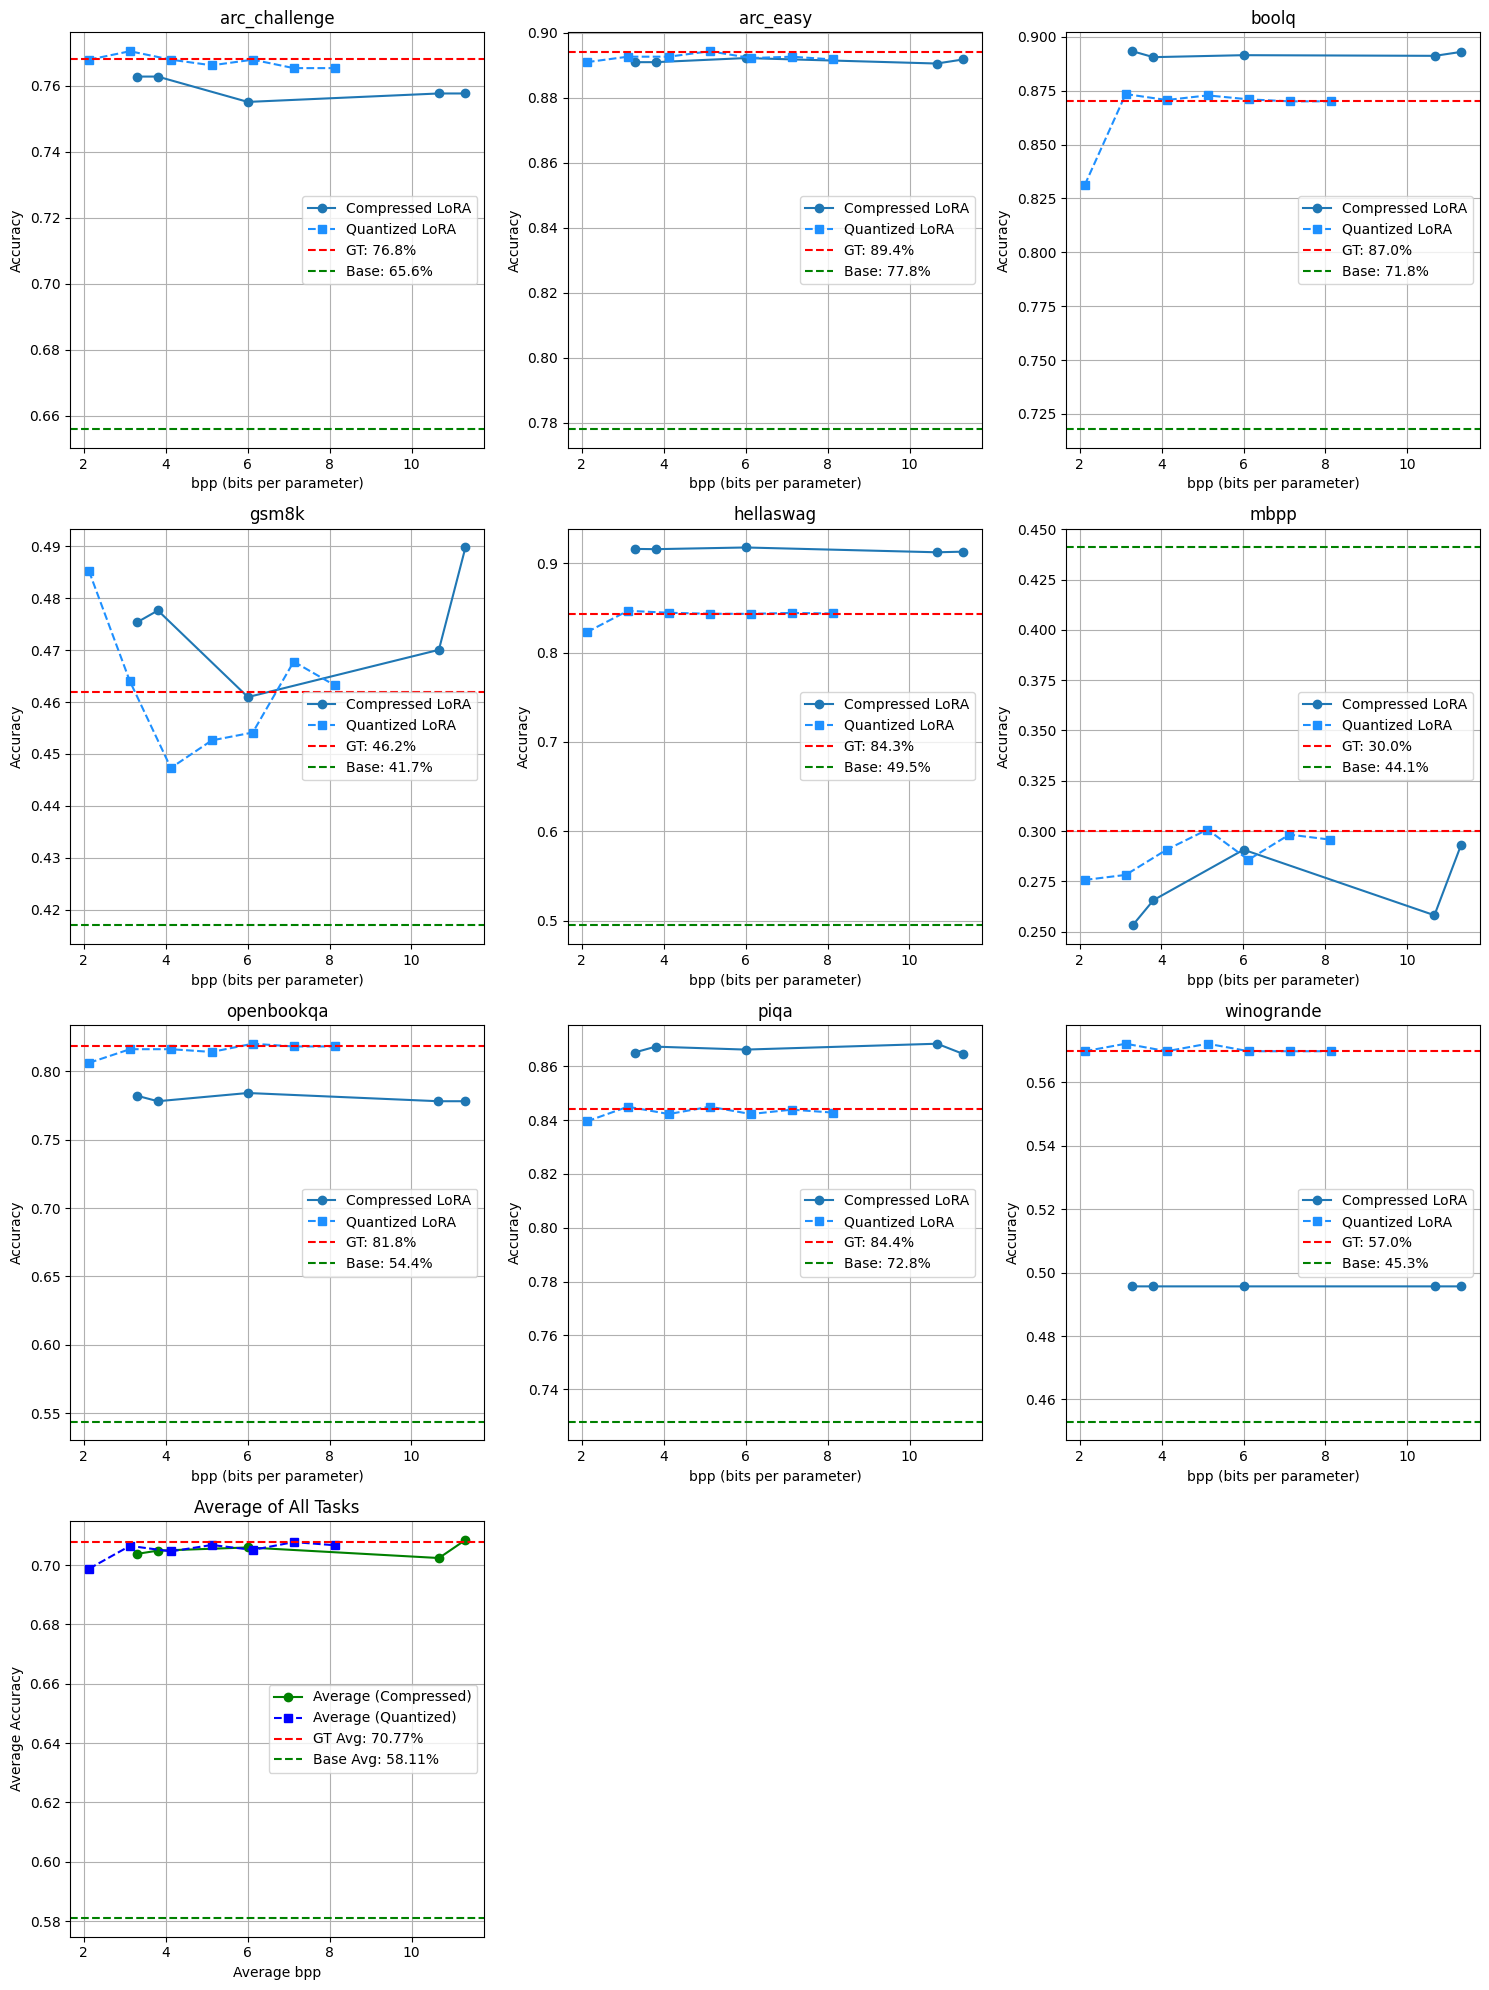

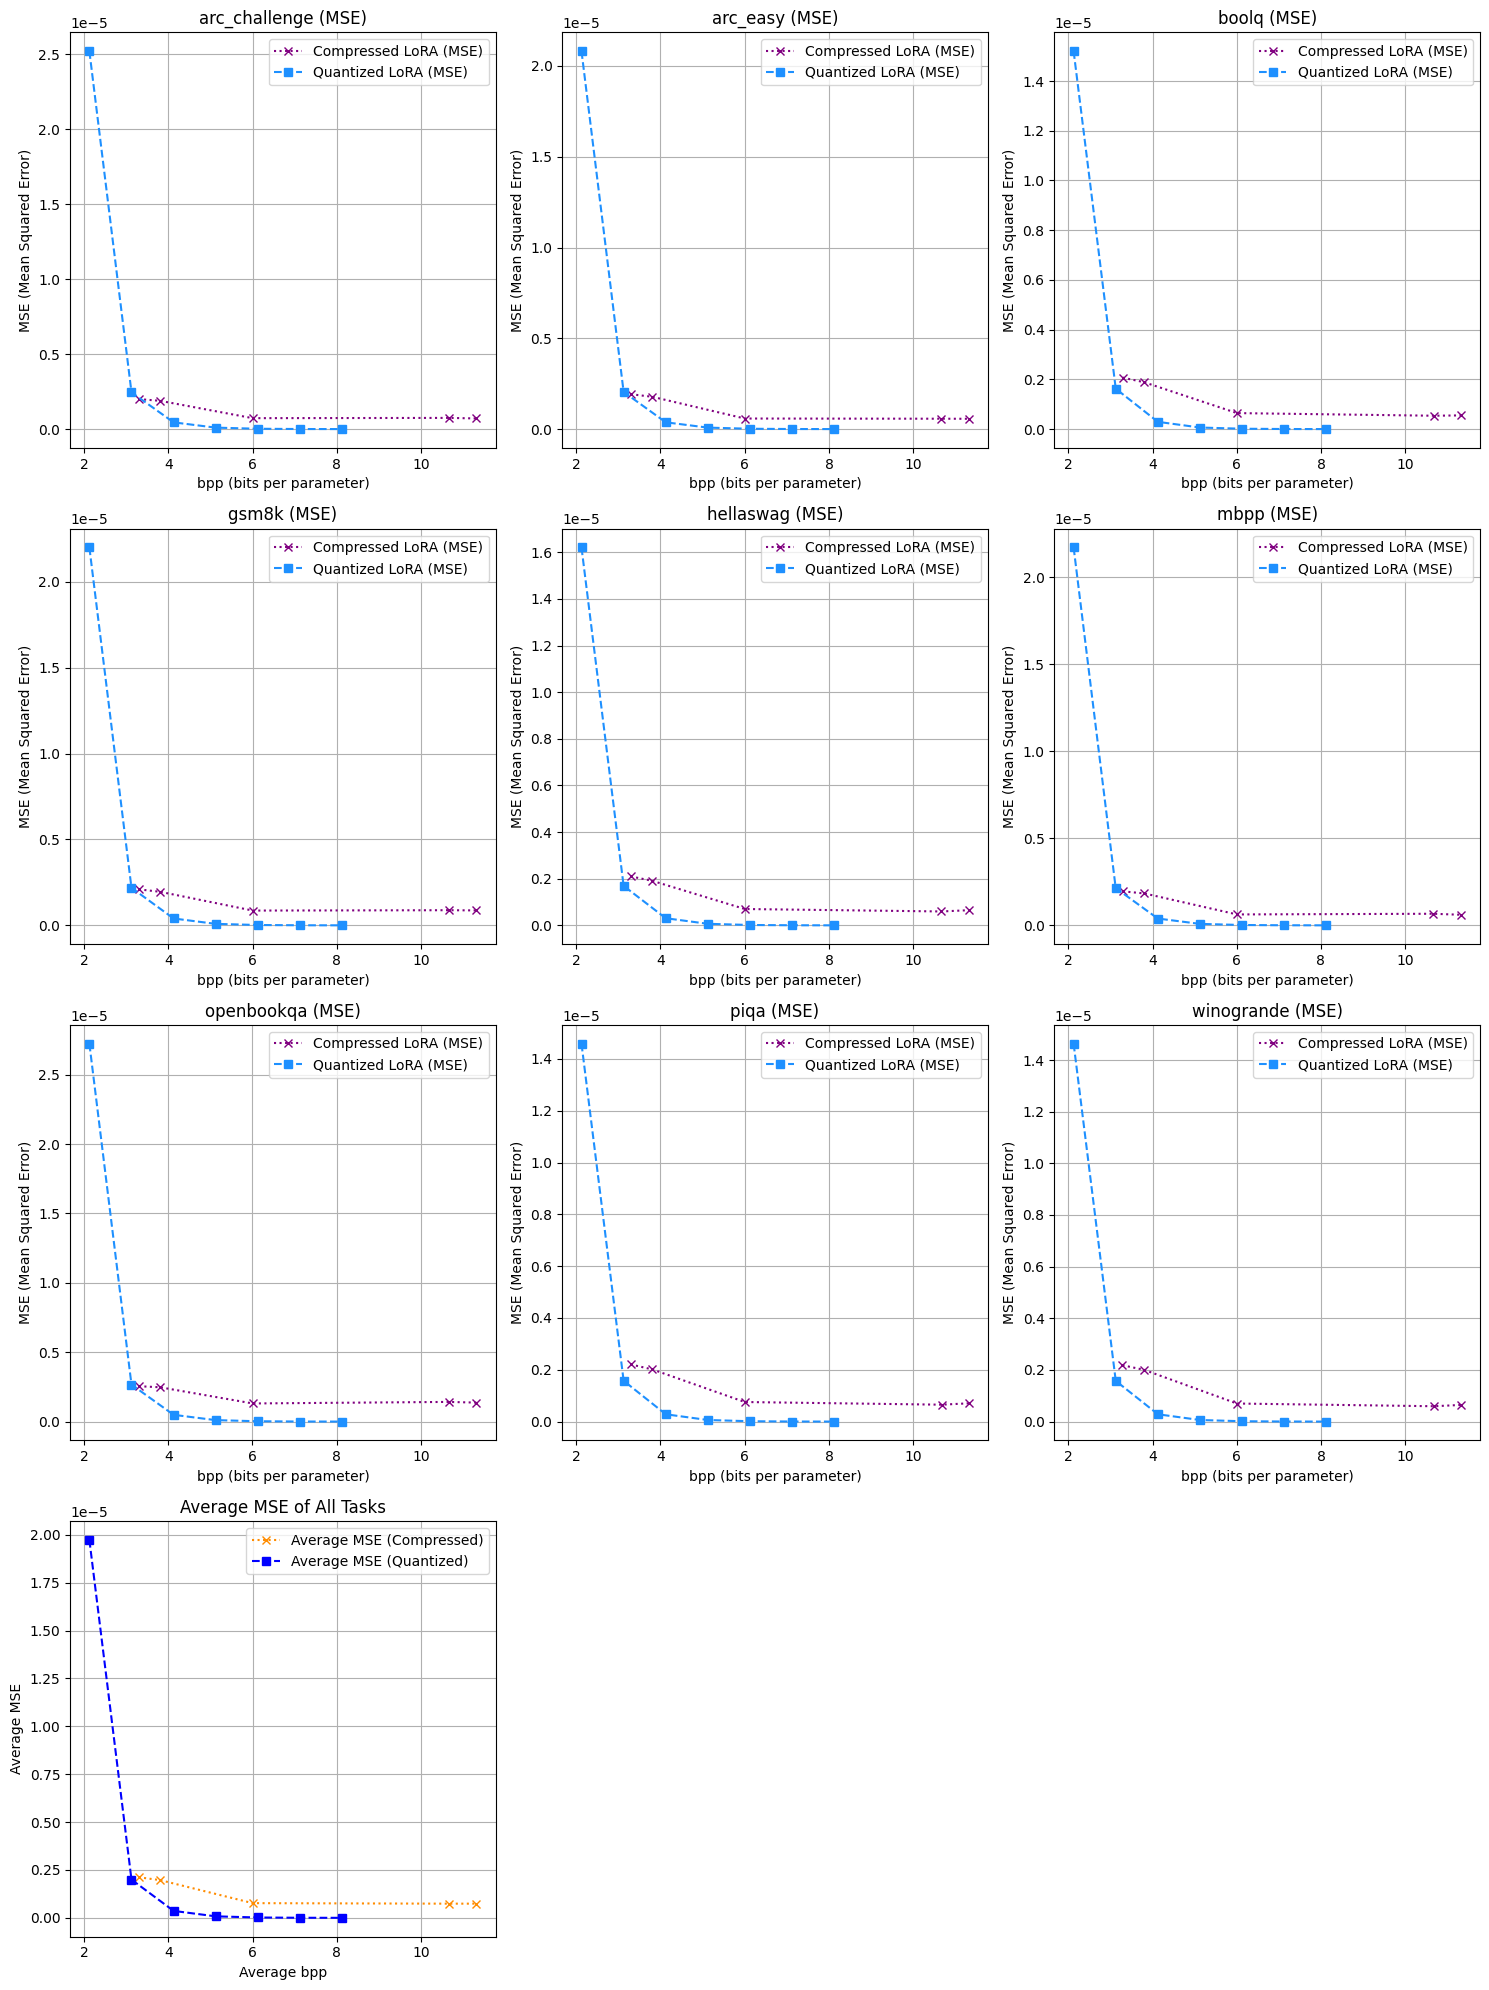

In [ ]:


# ==================== 1. 데이터 재구성 (두 데이터셋 모두 처리, acc/mse 모두) ====================
# total_result 처리
task_data = defaultdict(lambda: {'bpp': [], 'acc': [], 'mse': []})
average_data = defaultdict(list)
data = total_result

for step, tasks_data in data.items():
    step_bpps, step_accs, step_mses = [], [], []
    for task_name, metrics in tasks_data.items():
        if task_name not in tasks: continue
        bpp, mse = metrics['bpp'], metrics.get('mse', 0.0)
        acc = metrics.get('acc') or metrics.get('mbpp_base_pass@1')
        
        task_data[task_name]['bpp'].append(bpp)
        task_data[task_name]['acc'].append(acc)
        task_data[task_name]['mse'].append(mse)
        
        step_bpps.append(bpp); step_accs.append(acc); step_mses.append(mse)
    
    if step_bpps:
        average_data['bpp'].append(np.mean(step_bpps))
        average_data['acc'].append(np.mean(step_accs))
        average_data['mse'].append(np.mean(step_mses))

# quant_result 처리 (acc 추가)
quant_task_data = defaultdict(lambda: {'bpp': [], 'mse': [], 'acc': []})
quant_average_data = defaultdict(list)

for step, tasks_data in quant_result.items():
    step_bpps, step_mses, step_accs = [], [], []
    for task_name, metrics in tasks_data.items():
        if task_name not in tasks: continue
        bpp, mse = metrics['bpp'], metrics.get('mse', 0.0)
        acc = metrics.get('acc') or metrics.get('mbpp_base_pass@1')
        
        if acc is None:
             print(f"Warning: Accuracy not found for task '{task_name}' in quant_result. Skipping for accuracy plots.")
             continue

        quant_task_data[task_name]['bpp'].append(bpp)
        quant_task_data[task_name]['mse'].append(mse)
        quant_task_data[task_name]['acc'].append(acc)
        
        step_bpps.append(bpp); step_mses.append(mse); step_accs.append(acc)

    if step_bpps:
        quant_average_data['bpp'].append(np.mean(step_bpps))
        quant_average_data['mse'].append(np.mean(step_mses))
        quant_average_data['acc'].append(np.mean(step_accs))
# =================================================================================

# ==================== 2. 정확도(Accuracy) 그래프 그리기 (Quantized LoRA 추가) ====================
task_names = sorted(task_data.keys())
num_tasks = len(task_names)
num_plots = num_tasks + 1
cols = 3
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

for i, task_name in enumerate(task_names):
    ax = axes[i]
    
    # 1. 기존 데이터 (Compressed LoRA) 그리기
    points = sorted(zip(task_data[task_name]['bpp'], task_data[task_name]['acc']))
    bpp_sorted = [p[0] for p in points]
    acc_sorted = [p[1] for p in points]
    ax.plot(bpp_sorted, acc_sorted, marker='o', linestyle='-', label='Compressed LoRA')
    
    # 2. 새로운 데이터 (Quantized LoRA) 그리기
    if task_name in quant_task_data and quant_task_data[task_name].get('acc'):
        quant_points = sorted(zip(quant_task_data[task_name]['bpp'], quant_task_data[task_name]['acc']))
        quant_bpp_sorted = [p[0] for p in quant_points]
        quant_acc_sorted = [p[1] for p in quant_points]
        ax.plot(quant_bpp_sorted, quant_acc_sorted, marker='s', linestyle='--', color='dodgerblue', label='Quantized LoRA')

    # GT, Base 라인 그리기
    if task_name in gt_map:
        gt_value, b_value = gt_map[task_name], base_map[task_name]
        ax.axhline(y=gt_value / 100.0, color='r', linestyle='--', label=f'GT: {gt_value}%')
        ax.axhline(y=b_value / 100.0, color='g', linestyle='--', label=f'Base: {b_value}%')
    ax.legend()
    
    ax.set_title(task_name)
    ax.set_xlabel("bpp (bits per parameter)")
    ax.set_ylabel("Accuracy")
    ax.grid(True)

# 정확도 평균 그래프
ax = axes[num_tasks]
# 1. 기존 데이터 평균
avg_points = sorted(zip(average_data['bpp'], average_data['acc']))
ax.plot([p[0] for p in avg_points], [p[1] for p in avg_points], marker='o', linestyle='-', color='green', label='Average (Compressed)')
# 2. 새로운 데이터 평균
if quant_average_data.get('acc'):
    quant_avg_points = sorted(zip(quant_average_data['bpp'], quant_average_data['acc']))
    ax.plot([p[0] for p in quant_avg_points], [p[1] for p in quant_avg_points], marker='s', linestyle='--', color='blue', label='Average (Quantized)')

ax.axhline(y=np.mean(gt) / 100.0, color='r', linestyle='--', label=f'GT Avg: {np.mean(gt):.2f}%')
ax.axhline(y=np.mean(base) / 100.0, color='g', linestyle='--', label=f'Base Avg: {np.mean(base):.2f}%')
ax.set_title("Average of All Tasks")
ax.set_xlabel("Average bpp")
ax.set_ylabel("Average Accuracy")
ax.grid(True)
ax.legend()

for j in range(num_plots, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
# plt.savefig("bpp_vs_acc_comparison.png")
# print("정확도 비교 그래프가 'bpp_vs_acc_comparison.png' 파일로 저장되었습니다.")


# ==================== 3. MSE 그래프 그리기 (기존 코드와 동일) ====================
fig_mse, axes_mse = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes_mse = axes_mse.flatten()

for i, task_name in enumerate(task_names):
    ax = axes_mse[i]
    
    points = sorted(zip(task_data[task_name]['bpp'], task_data[task_name]['mse']))
    ax.plot([p[0] for p in points], [p[1] for p in points], marker='x', linestyle=':', color='purple', label='Compressed LoRA (MSE)')
    
    if task_name in quant_task_data:
        quant_points = sorted(zip(quant_task_data[task_name]['bpp'], quant_task_data[task_name]['mse']))
        ax.plot([p[0] for p in quant_points], [p[1] for p in quant_points], marker='s', linestyle='--', color='dodgerblue', label='Quantized LoRA (MSE)')

    ax.set_title(f"{task_name} (MSE)")
    ax.set_xlabel("bpp (bits per parameter)")
    ax.set_ylabel("MSE (Mean Squared Error)")
    ax.grid(True)
    ax.legend()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax = axes_mse[num_tasks]
avg_points_mse = sorted(zip(average_data['bpp'], average_data['mse']))
ax.plot([p[0] for p in avg_points_mse], [p[1] for p in avg_points_mse], marker='x', linestyle=':', color='darkorange', label='Average MSE (Compressed)')
quant_avg_points_mse = sorted(zip(quant_average_data['bpp'], quant_average_data['mse']))
ax.plot([p[0] for p in quant_avg_points_mse], [p[1] for p in quant_avg_points_mse], marker='s', linestyle='--', color='blue', label='Average MSE (Quantized)')

ax.set_title("Average MSE of All Tasks")
ax.set_xlabel("Average bpp")
ax.set_ylabel("Average MSE")
ax.grid(True)
ax.legend()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

for j in range(num_plots, len(axes_mse)):
    axes_mse[j].set_visible(False)

plt.tight_layout()
# plt.savefig("bpp_vs_mse_by_task_comparison.png")
# print("MSE 비교 그래프가 'bpp_vs_mse_by_task_comparison.png' 파일로 저장되었습니다.")

plt.show()